# Задание 8. Работа с текстовыми данными(часть 1).


## Написание кода
### Для начала импортируем все нужные библиотеки и загрузим датасет.

In [ ]:
#проверка, что модели адекватно скачались
!python -m spacy validate

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.8.8) =================
ℹ spaCy installation: /usr/local/lib/python3.12/dist-packages/spacy

NAME             SPACY            VERSION                            
en_core_web_sm   >=3.8.0,<3.9.0   3.8.0   ✔



In [ ]:
# скачать модель для русского языка
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
%pip install nltk

In [ ]:
%pip install pymystem3

In [ ]:

import spacy
from spacy import displacy

import os
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from pymystem3 import Mystem
from nltk.corpus import stopwords
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/DataSet13_1.csv')
df.head()

,id,text,author
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,Dostoevsky
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",Dostoevsky
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",Dostoevsky
3,3,Мы высказали только главную передовую мысль на...,Dostoevsky
4,4,"I. Отдел литературный. Повести, романы, расска...",Dostoevsky


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1734 non-null   int64 
 1   text    1734 non-null   object
 2   author  1734 non-null   object
dtypes: int64(1), object(2)
memory usage: 40.8+ KB


Описание датасета:

| Название колонки        | Описание |
|------------------------|----------|
| **id**         | Уникальный идентификатор текста в датасете. |
| **text**| Текстовое содержание. |
| **author**     | Автор. |

## Подготовка данных


In [ ]:
# проверим наличие дубликатов
df.duplicated().sum()

np.int64(0)

Преобразуем автора в число (1 если Достоевский и 0 если любой другой)

In [ ]:
df['class'] = df['author'].apply(lambda x: 1 if x == 'Dostoevsky' else 0)

# Удаление столбца 'author'
df = df.drop('author', axis=1)

df.head()

,id,text,class
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,1
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",1
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",1
3,3,Мы высказали только главную передовую мысль на...,1
4,4,"I. Отдел литературный. Повести, романы, расска...",1


Очистка и лемманизация

In [ ]:
mystem = Mystem() # инициализируем морфологический анализатор

nltk.download('stopwords') # скачиваем стоп-слова
russian_stopwords = stopwords.words("russian")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re


def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление всех символов, кроме кириллицы и пробелов (удаляет пунктуацию, цифры, спецсимволы)
    text = re.sub(r'[^а-яё ]', '', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    # Лемматизация с помощью Mystem
    lemmas = mystem.lemmatize(text)

    return ''.join(lemmas).strip()

In [ ]:
# применим функцию к каждому тексту в датафрейме
df['Text_clean'] = df['text'].apply(preprocess_text)

In [ ]:
nlp_rus = spacy.load("ru_core_news_sm")

## Частеречная разметка

In [ ]:
import warnings

# Убрать предупреждения
warnings.filterwarnings('ignore')

# Функция для применения разбиения на части речи к тексту
def apply_pos(text):
    doc = nlp_rus(text)
    pos_tags = [token.pos_ for token in doc]
    return np.array(pos_tags)

# Создание пустого датафрейма
data = pd.DataFrame()

for i in range(df.shape[0]):
    PoS_list = apply_pos(df.iloc[i]['Text_clean'])
    data = pd.concat([data, pd.DataFrame({
    'ADJ': [np.sum(np.where(PoS_list == 'ADJ')[0])/np.where(PoS_list == 'ADJ')[0].shape[0]],
    'ADJ_col': [np.where(PoS_list == 'ADJ')[0].shape[0]],
    'ADP': [np.sum(np.where(PoS_list == 'ADP')[0])/np.where(PoS_list == 'ADP')[0].shape[0]],
    'ADP_col': [np.where(PoS_list == 'ADP')[0].shape[0]],
    'ADV': [np.sum(np.where(PoS_list == 'ADV')[0])/np.where(PoS_list == 'ADV')[0].shape[0]],
    'ADV_col': [np.where(PoS_list == 'ADV')[0].shape[0]],
    'AUX': [np.sum(np.where(PoS_list == 'AUX')[0])/np.where(PoS_list == 'AUX')[0].shape[0]],
    'AUX_col': [np.where(PoS_list == 'AUX')[0].shape[0]],
    'CCONJ': [np.sum(np.where(PoS_list == 'CCONJ')[0])/np.where(PoS_list == 'CCONJ')[0].shape[0]],
    'CCONJ_col': [np.where(PoS_list == 'CCONJ')[0].shape[0]],
    'DET': [np.sum(np.where(PoS_list == 'DET')[0])/np.where(PoS_list == 'DET')[0].shape[0]],
    'DET_col': [np.where(PoS_list == 'DET')[0].shape[0]],
    'INTJ': [np.sum(np.where(PoS_list == 'INTJ')[0])/np.where(PoS_list == 'INTJ')[0].shape[0]],
    'INTJ_col': [np.where(PoS_list == 'INTJ')[0].shape[0]],
    'NOUN': [np.sum(np.where(PoS_list == 'NOUN')[0])/np.where(PoS_list == 'NOUN')[0].shape[0]],
    'NOUN_col': [np.where(PoS_list == 'NOUN')[0].shape[0]],
    'NUM': [np.sum(np.where(PoS_list == 'NUM')[0])/np.where(PoS_list == 'NUM')[0].shape[0]],
    'NUM_col': [np.where(PoS_list == 'NUM')[0].shape[0]],
    'PART': [np.sum(np.where(PoS_list == 'PART')[0])/np.where(PoS_list == 'PART')[0].shape[0]],
    'PART_col': [np.where(PoS_list == 'PART')[0].shape[0]],
    'PRON': [np.sum(np.where(PoS_list == 'PRON')[0])/np.where(PoS_list == 'PRON')[0].shape[0]],
    'PRON_col': [np.where(PoS_list == 'PRON')[0].shape[0]],
    'PUNCT': [np.sum(np.where(PoS_list == 'PUNCT')[0])/np.where(PoS_list == 'PUNCT')[0].shape[0]],
    'PUNCT_col': [np.where(PoS_list == 'PUNCT')[0].shape[0]],
    'SCONJ': [np.sum(np.where(PoS_list == 'SCONJ')[0])/np.where(PoS_list == 'SCONJ')[0].shape[0]],
    'SCONJ_col': [np.where(PoS_list == 'SCONJ')[0].shape[0]],
    'VERB': [np.sum(np.where(PoS_list == 'VERB')[0])/np.where(PoS_list == 'VERB')[0].shape[0]],
    'VERB_col': [np.where(PoS_list == 'VERB')[0].shape[0]],
    })], axis=0)

In [ ]:
data = data.reset_index()
data = data.drop(columns='index')
data.head()

,ADJ,ADJ_col,ADP,ADP_col,ADV,ADV_col,AUX,AUX_col,CCONJ,CCONJ_col,...,PART,PART_col,PRON,PRON_col,PUNCT,PUNCT_col,SCONJ,SCONJ_col,VERB,VERB_col
0,141.612903,31,132.555556,27,134.470588,17,171.600000,5,120.333333,15,...,171.700000,10,113.814815,27,NaN,0,131.142857,7,129.191489,47
1,353.828571,70,356.060606,66,329.568627,51,347.227273,22,356.294118,34,...,288.980000,50,283.220000,50,NaN,0,415.400000,20,364.280992,121
2,53.500000,8,30.857143,7,49.000000,9,85.000000,2,41.000000,1,...,66.750000,4,55.666667,9,NaN,0,54.000000,3,52.880000,25
3,423.966102,118,366.129870,77,359.367647,68,484.142857,7,400.963636,55,...,425.040816,49,345.028571,35,NaN,0,411.625000,16,380.660550,109
4,74.566667,30,108.526316,19,106.444444,9,164.000000,1,58.300000,10,...,114.777778,9,148.500000,8,NaN,0,113.500000,4,106.944444,18


In [ ]:
data = data.fillna(0) #не все части речи есть во всех предложениях, так что нам нужно избавиться от na

#добавим в полученный датафрейм колонку класс
data['Сlass'] = df['class']

#перемешиваем данные
data = data.sample(frac=1).reset_index(drop=True)

## Строим модели

In [ ]:
X = data.drop(columns=['Сlass'])
y = data['Сlass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# KNeighbors
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

In [ ]:
# SVM с RBF ядром
model_svm = SVC(
    kernel='rbf',
    random_state=42,
    probability=True
)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)


In [ ]:
# Логистическая регрессия
model_lr = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

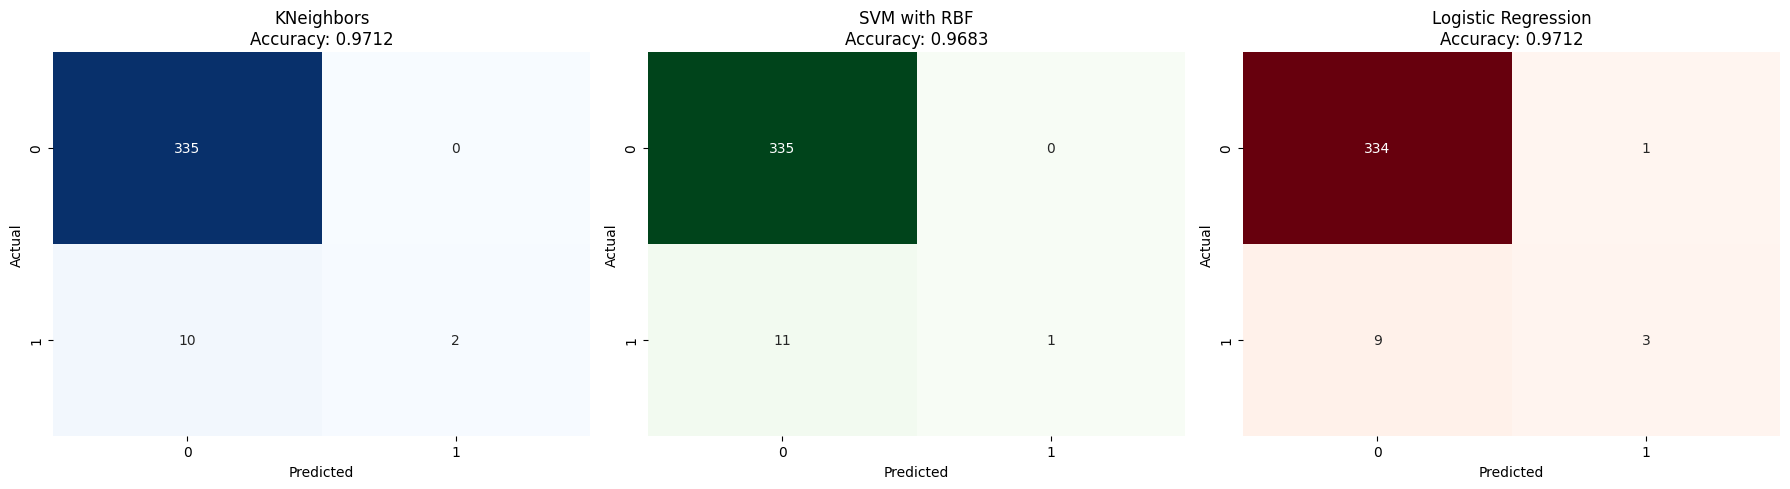

In [ ]:
# Холст для 3 матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Матрица confussion
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'KNeighbors\nAccuracy: {accuracy_knn:.4f}')

# Матрица для SVM с RBF
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Greens',
            cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'SVM with RBF\nAccuracy: {accuracy_svm:.4f}')

# Матрица для Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Reds',
            cbar=False, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title(f'Logistic Regression\nAccuracy: {accuracy_lr:.4f}')

plt.tight_layout()
plt.show()

## Сравнение по метрика

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Формируем модели
models = {
    'KNeighbors': y_pred_knn,
    'SVM RBF': y_pred_svm,
    'Logistic Regression': y_pred_lr
}

# Создаем таблицу с метриками
results = []
for name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

In [ ]:
# Выводим сравнительную таблицу
results_df = pd.DataFrame(results)
print("\nСравнительная таблица метрик:")
print("=" * 60)
print(results_df.round(4))
print("=" * 60)


Сравнительная таблица метрик:
                 Model  Accuracy  Precision  Recall  F1-Score
0           KNeighbors    0.9712       1.00  0.1667    0.2857
1              SVM RBF    0.9683       1.00  0.0833    0.1538
2  Logistic Regression    0.9712       0.75  0.2500    0.3750


## ROC-кривые

In [ ]:
y_prob_knn = model_knn.predict_proba(X_test)
y_prob_svm = model_svm.predict_proba(X_test)
y_prob_lr = model_lr.predict_proba(X_test)

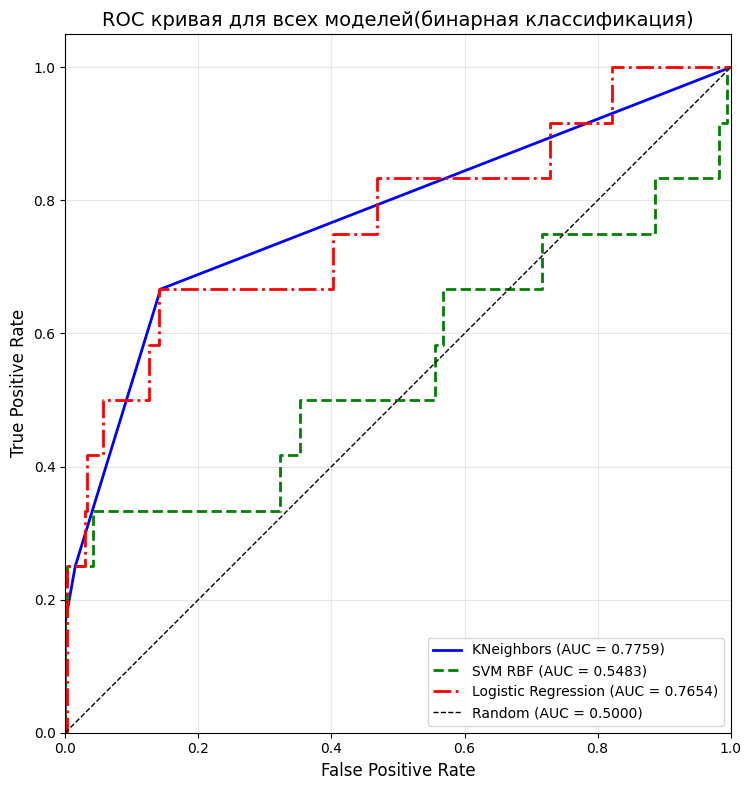

In [ ]:
# Создаем график для ROC-кривых
plt.figure(figsize=(10, 8))

# Модели и их вероятности для положительного класса (класс 1)
models_proba = {
    'KNeighbors': y_prob_knn[:, 1],  # берем вероятности для класса 1
    'SVM RBF': y_prob_svm[:, 1],
    'Logistic Regression': y_prob_lr[:, 1]
}

# Цвета для разных моделей
colors = ['blue', 'green', 'red']
linestyles = ['-', '--', '-.']

# Вычисляем и рисуем ROC-кривые для каждой модели
for i, (name, y_prob_positive) in enumerate(models_proba.items()):
    # Для бинарной классификации вычисляем одну ROC-кривую
    fpr, tpr, _ = roc_curve(y_test, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Рисуем ROC-кривую
    plt.plot(fpr, tpr,
             color=colors[i],
             linestyle=linestyles[i],
             lw=2,
             label=f'{name} (AUC = {roc_auc:.4f})')

# Рисуем диагональ (случайный классификатор)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5000)')

# Настройки графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC кривая для всех моделей(бинарная классификация)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Добавляем сетку и оформление
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

5 аздание


In [ ]:
def extract_syntactic_features(texts):
    """
    Извлекает синтаксические характеристики из текстов
    - Средняя длина предложения
    - Сложность синтаксических конструкций (количество и позиция знаков препинания)
    """
    features = []

    for text in texts:
        doc = nlp_rus(str(text))
        sentences = list(doc.sents)

        # 1. Средняя длина предложения
        if sentences:
            sentence_lengths = [len([token for token in sent if not token.is_space]) for sent in sentences]
            avg_sentence_length = np.mean(sentence_lengths)
        else:
            avg_sentence_length = 0

        # 2. Количество знаков препинания
        punctuation_count = len([token for token in doc if token.is_punct])

        # 3. Позиция знаков препинания (относительная позиция в предложениях)
        punctuation_positions = []
        for sent in sentences:
            sent_tokens = [token for token in sent if not token.is_space]
            if sent_tokens:
                for i, token in enumerate(sent_tokens):
                    if token.is_punct:
                        relative_position = i / len(sent_tokens)
                        punctuation_positions.append(relative_position)

        if punctuation_positions:
            avg_punctuation_position = np.mean(punctuation_positions)
            std_punctuation_position = np.std(punctuation_positions)
        else:
            avg_punctuation_position = 0
            std_punctuation_position = 0

        # 4. Плотность знаков препинания
        total_tokens = len([token for token in doc if not token.is_space])
        punctuation_density = punctuation_count / total_tokens if total_tokens > 0 else 0

        features.append({
            'avg_sentence_length': avg_sentence_length,
            'punctuation_count': punctuation_count,
            'punctuation_density': punctuation_density,
            'avg_punctuation_position': avg_punctuation_position,
            'std_punctuation_position': std_punctuation_position
        })

    return pd.DataFrame(features)


texts = df['text']  # Укажите правильное название столбца

print("Извлекаем синтаксические характеристики...")
syntactic_features = extract_syntactic_features(texts)

print("Синтаксические характеристики:")
print(syntactic_features.head())

data_combined = pd.concat([data, syntactic_features], axis=1)

print("\nОбъединенный датафрейм:")
print(f"Исходные столбцы: {data.shape[1]}")
print(f"Новые столбцы: {syntactic_features.shape[1]}")
print(f"Всего столбцов: {data_combined.shape[1]}")
print(f"Строки: {data_combined.shape[0]}")


print("\nСтолбцы объединенного датафрейма:")
print(data_combined.columns.tolist())



print("Готово! Синтаксические характеристики добавлены к вашему датафрейму.")

Извлекаем синтаксические характеристики...
Синтаксические характеристики:
   avg_sentence_length  punctuation_count  punctuation_density  \
0            16.550000                 56             0.169184   
1            22.342105                144             0.169611   
2            11.916667                 33             0.230769   
3            16.949153                181             0.181000   
4             8.666667                 56             0.215385   

   avg_punctuation_position  std_punctuation_position  
0                  0.629754                  0.283027  
1                  0.593677                  0.291797  
2                  0.577947                  0.289427  
3                  0.564573                  0.292236  
4                  0.587828                  0.260700  

Объединенный датафрейм:
Исходные столбцы: 29
Новые столбцы: 5
Всего столбцов: 34
Строки: 1734

Столбцы объединенного датафрейма:
['ADJ', 'ADJ_col', 'ADP', 'ADP_col', 'ADV', 'ADV_col', 'AUX', '

In [ ]:
data_combined = data_combined.reset_index()
data_combined = data_combined.drop(columns='index')
data_combined.head()

,ADJ,ADJ_col,ADP,ADP_col,ADV,ADV_col,AUX,AUX_col,CCONJ,CCONJ_col,...,SCONJ,SCONJ_col,VERB,VERB_col,Сlass,avg_sentence_length,punctuation_count,punctuation_density,avg_punctuation_position,std_punctuation_position
0,381.575342,73,341.902439,82,385.307692,52,389.055556,18,422.742857,35,...,386.800000,10,331.905109,137,0,16.550000,56,0.169184,0.629754,0.283027
1,53.500000,10,30.000000,11,38.333333,3,0.000000,0,67.500000,2,...,7.500000,2,46.636364,22,0,22.342105,144,0.169611,0.593677,0.291797
2,27.384615,13,43.875000,8,53.000000,8,0.000000,0,62.000000,4,...,60.000000,1,62.000000,11,0,11.916667,33,0.230769,0.577947,0.289427
3,57.500000,8,73.846154,13,37.375000,8,38.000000,3,90.833333,6,...,92.333333,3,74.096774,31,0,16.949153,181,0.181000,0.564573,0.292236
4,116.387097,31,115.458333,24,111.454545,11,89.750000,4,113.777778,9,...,136.000000,3,95.444444,45,0,8.666667,56,0.215385,0.587828,0.260700


## Строим новые модели

In [ ]:
X = data_combined.drop(columns=['Сlass'])
y = data_combined['Сlass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# KNeighbors
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

In [ ]:
# SVM с RBF ядром
model_svm = SVC(
    kernel='rbf',
    random_state=42,
    probability=True
)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)


In [ ]:
# Логистическая регрессия
model_lr = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

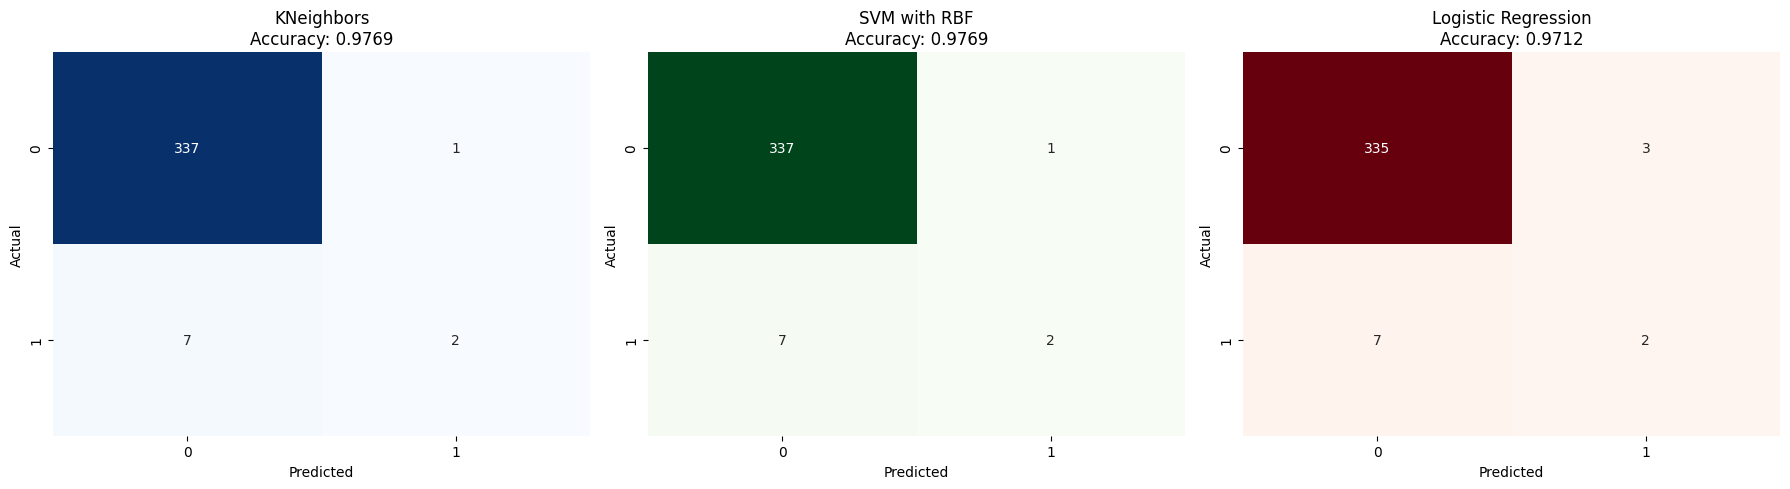

In [ ]:
# Холст для 3 матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Матрица confussion
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'KNeighbors\nAccuracy: {accuracy_knn:.4f}')

# Матрица для SVM с RBF
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Greens',
            cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'SVM with RBF\nAccuracy: {accuracy_svm:.4f}')

# Матрица для Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Reds',
            cbar=False, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title(f'Logistic Regression\nAccuracy: {accuracy_lr:.4f}')

plt.tight_layout()
plt.show()

## Сравнение по метрика

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Формируем модели
models = {
    'KNeighbors': y_pred_knn,
    'SVM RBF': y_pred_svm,
    'Logistic Regression': y_pred_lr
}

# Создаем таблицу с метриками
results = []
for name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

In [ ]:
# Выводим сравнительную таблицу
results_df = pd.DataFrame(results)
print("\nСравнительная таблица метрик:")
print("=" * 60)
print(results_df.round(4))
print("=" * 60)


Сравнительная таблица метрик:
                 Model  Accuracy  Precision  Recall  F1-Score
0           KNeighbors    0.9712       1.00  0.1667    0.2857
1              SVM RBF    0.9683       1.00  0.0833    0.1538
2  Logistic Regression    0.9712       0.75  0.2500    0.3750


## ROC-кривые

In [ ]:
y_prob_knn = model_knn.predict_proba(X_test)
y_prob_svm = model_svm.predict_proba(X_test)
y_prob_lr = model_lr.predict_proba(X_test)

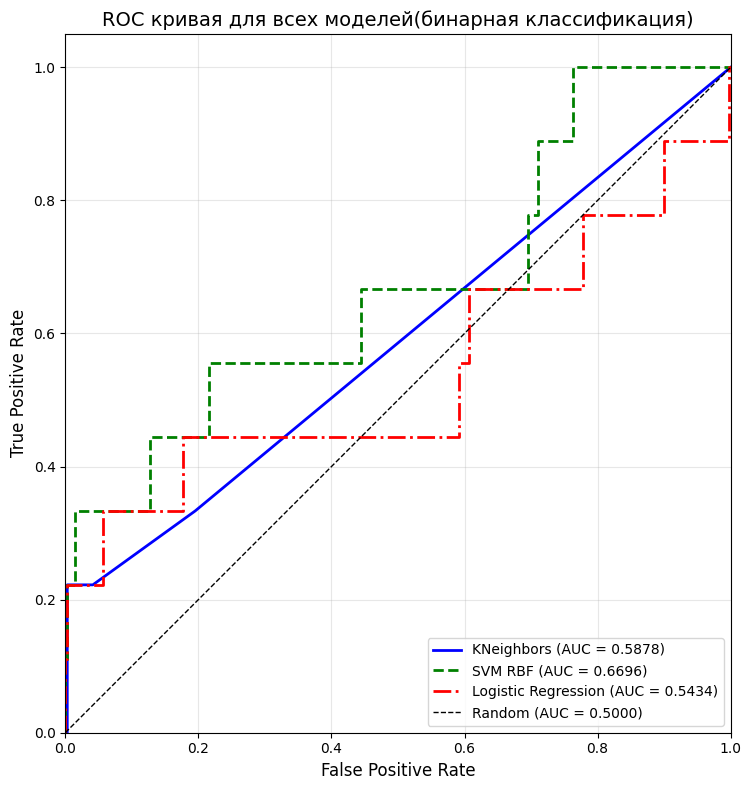

In [ ]:
# Создаем график для ROC-кривых
plt.figure(figsize=(10, 8))

# Модели и их вероятности для положительного класса (класс 1)
models_proba = {
    'KNeighbors': y_prob_knn[:, 1],  # берем вероятности для класса 1
    'SVM RBF': y_prob_svm[:, 1],
    'Logistic Regression': y_prob_lr[:, 1]
}

# Цвета для разных моделей
colors = ['blue', 'green', 'red']
linestyles = ['-', '--', '-.']

# Вычисляем и рисуем ROC-кривые для каждой модели
for i, (name, y_prob_positive) in enumerate(models_proba.items()):
    # Для бинарной классификации вычисляем одну ROC-кривую
    fpr, tpr, _ = roc_curve(y_test, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Рисуем ROC-кривую
    plt.plot(fpr, tpr,
             color=colors[i],
             linestyle=linestyles[i],
             lw=2,
             label=f'{name} (AUC = {roc_auc:.4f})')

# Рисуем диагональ (случайный классификатор)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5000)')

# Настройки графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC кривая для всех моделей(бинарная классификация)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Добавляем сетку и оформление
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()